# Investigación sobre supervivencia pasajeros de R.M.S. Titanic. - ULS Programación  Avanzada 2023


# Carga de archivo

Se carga archivo .CSV con DataSet de pasajeros de R.M.S. Titanic.

In [173]:
from pyspark.sql import SparkSession

# Sesion Spark, Y puerto de Spark Master
spark = SparkSession.builder \
    .appName("Spark_PA") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

# Se guarda en una variable la ruta de archivo .CSV dentro del Container. En este caso esta deltro de directorio WORK
csv_path = "/home/jovyan/work/train.csv"

# Se informacion de CSV en un PySpark DataFrame. df
df = spark.read.csv(csv_path, header=True)

# Se muestran las primeras tuplas, Sin acortar
print(" --> PRIMERAS 10 TUPLAS DE PASAJEROS\n")
df.show(10, truncate=False)

 --> PRIMERAS 10 TUPLAS DE PASAJEROS

+-----------+--------+------+---------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|Name                                               |Sex   |Age |SibSp|Parch|Ticket          |Fare   |Cabin|Embarked|
+-----------+--------+------+---------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|1          |0       |3     |Braund, Mr. Owen Harris                            |male  |22  |1    |0    |A/5 21171       |7.25   |NULL |S       |
|2          |1       |1     |Cumings, Mrs. John Bradley (Florence Briggs Thayer)|female|38  |1    |0    |PC 17599        |71.2833|C85  |C       |
|3          |1       |3     |Heikkinen, Miss. Laina                             |female|26  |0    |0    |STON/O2. 3101282|7.925  |NULL |S       |
|4          |1       |1     |Futrelle, Mrs. Jacques Heath (Lily May Peel)       |femal

#### - Para mantener solo las columnas relevante para este estudio, Se truncan el resto de columnas.

In [286]:
columnas_relevantes = ["Survived", "Pclass", "Sex", "Age"]

df = df.select(*columnas_relevantes)

df.show(5)

+--------+------+----+---+
|Survived|Pclass| Sex|Age|
+--------+------+----+---+
|       0|     1|male| 24|
|       1|     3|male| 32|
|       1|     3|male| 32|
|       1|     3|male| 32|
|       0|     2|male| 54|
+--------+------+----+---+
only showing top 5 rows



- - - 

# Edad promedio de supervivientes

In [174]:
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("prom_edad").getOrCreate()


# Spark Workers
df = df.repartition(2)

# Pasajero sobrevive o fallece
condicion_sobrevive = "1"
condicion_fallece = "0"

resultado_combinado = df.groupBy("Survived") \
                       .agg(F.avg("Age").alias("averageValue")) \
                       .filter((df["Survived"] == condicion_sobrevive) | (df["Survived"] == condicion_fallece))

print("Edad promedio de supervivientes y fallecidos")
resultado_combinado.show()

Edad promedio de supervivientes y fallecidos
+--------+------------------+
|Survived|      averageValue|
+--------+------------------+
|       1|28.343689655172415|
|       0| 30.62617924528302|
+--------+------------------+



La edad promedio es casi la misma. <br>
Por lo que no es una buena variable para predecir supervivencia. <br><br>
- - -

# Género de fallecidos

In [177]:
spark = SparkSession.builder.appName("genero").getOrCreate()

# Spark Workers
df = df.repartition(2)

# Pasajeros que fallecen
resultado_fallece = df.filter((df["Survived"] == "0")) \
                  .groupBy("Sex") \
                  .agg(F.count("*").alias("Count"))


print("Cantidad de fallecidos por genero")
resultado_fallece.show()

Cantidad de fallecidos por genero
+------+-----+
|   Sex|Count|
+------+-----+
|female|   81|
|  male|  468|
+------+-----+



La mayoria de los fallecidos fueron hombres.

Parece una buena variable para predecir la supervivencia. Para comparar correctamente el porcentaje de fallecimiento de cada género se encuentra la cantidad de pasajeros de cada género que abordaron:

In [179]:
# Spark Workers
df = df.repartition(2)

# Cantidad total de hombres y mujeres a borodo
result_gender_count = df.groupBy("Sex") \
                        .agg(F.count("*").alias("Count")) \
                        .orderBy("Count", ascending=False)

print("Total pasajeros")
result_gender_count.show()

Total pasajeros
+------+-----+
|   Sex|Count|
+------+-----+
|  male|  577|
|female|  314|
+------+-----+



Con esta informacion se puede calcular independientemente por género cual es el porcentaje de supervivencia usando $[(cantidad\_superviviente \ / \ cantidad\_abordante) * 100]$ de cada genéro

In [158]:
total_mujeres = 314
total_hombres = 577
mujeres_fallecidas = 81
hombres_fallecidos = 468
mujeres_supervivientes = total_mujeres - mujeres_fallecidas
hombres_supervivientes = total_hombres - hombres_fallecidos

print(" Porcentaje de supervivencia de mujeres: %", (mujeres_supervivientes / total_mujeres)*100)
print(" Porcentaje de supervivencia de hombres: %", (hombres_supervivientes / total_hombres)*100)

 Porcentaje de supervivencia de mujeres: % 74.20382165605095
 Porcentaje de supervivencia de hombres: % 18.890814558058924


- Por lo tanto, Se puede decir que una mujer tenia aproximadamente 4 veces mas posibilidades de sobrevivir<br>
- - -

# Clase en la que viajaba el pasajero

In [181]:
spark = SparkSession.builder.appName("Clase").getOrCreate()

# Workers Spark
df = df.repartition(2)

# Query fallecidos
resultado_clase = df.filter(df["Survived"] == "0") \
                        .groupBy("Pclass") \
                        .agg(F.count("*").alias("Count")) \
                        .orderBy("Count", ascending=False)

print("Cantidad de fallecidos por tipo de Clase")
resultado_clase.show()

Cantidad de fallecidos por tipo de Clase
+------+-----+
|Pclass|Count|
+------+-----+
|     3|  372|
|     2|   97|
|     1|   80|
+------+-----+



Este resultado parece ser buen indicador para predecir la supervivencia de un pasajero.

Pareciera que mientras mas alta era la Clase en la que viajaba un pasajero (Upper), Mas esperanza tenía que sobrevivir.  

Para comprobar esto se usa la misma operacion que con el analisis anterior.  
$[(cantidad\_superviviente \ / \ cantidad\_abordante) * 100]$

In [184]:
df = df.repartition(2)

# pasajeros por clase
result_pclass_count = df.groupBy("Pclass") \
                        .agg(F.count("*").alias("Count")) \
                        .orderBy("Pclass")

print("Cantidad total de pasajeros en cada clase")
result_pclass_count.show()

Cantidad total de pasajeros en cada clase
+------+-----+
|Pclass|Count|
+------+-----+
|     1|  216|
|     2|  184|
|     3|  491|
+------+-----+



Ahora haciendo la operacion $[(cantidad\_superviviente \ / \ cantidad\_abordante) * 100]$

In [183]:
# Array con numeros de fallecidos contra total a bordo
total_pasajeros = [216, 184, 419]
pasajeros_fallecidos = [80, 97, 372]

supervivencia = [(total_pasajeros - pasajeros_fallecidos) / total_pasajeros * 100 for total_pasajeros, pasajeros_fallecidos in zip(total_pasajeros, pasajeros_fallecidos)]

print("Porcentaje de supervivencia por clase de pasajero")
print("-> 1ra clase (Upper), 2da clase (Middle), 3ra clase (Lower)\n")
print(supervivencia,"%")

Porcentaje de supervivencia por clase de pasajero
-> 1ra clase (Upper), 2da clase (Middle), 3ra clase (Lower)

[62.96296296296296, 47.28260869565217, 11.217183770883054] %


- - -

# Visualizando algunos datos

A continuacion se muestra de manera grafica la informacion relevante que se calculo durante el Notebook usando MatplotLib.

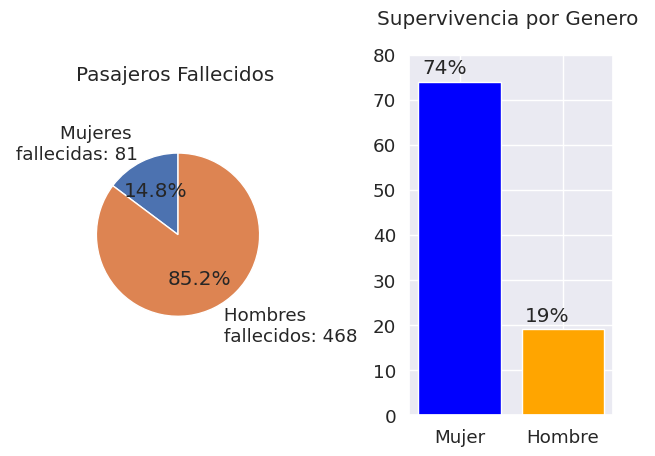

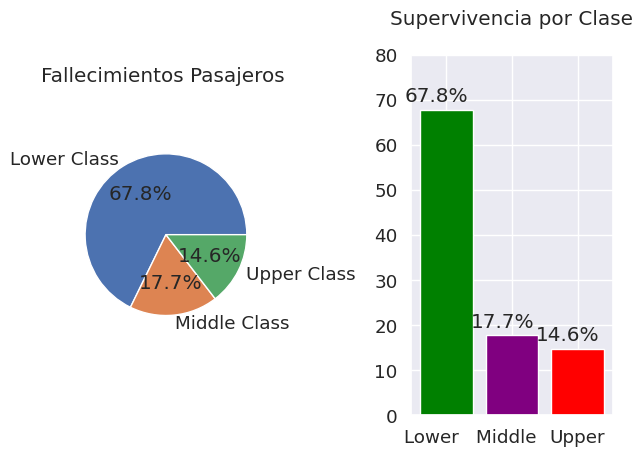

In [287]:
import matplotlib.pyplot as plt
#------------------------------>>>>>>>>>>>>>>>
# ### Graficos por GENERO


# Datos Tarta
values_pie = [81, 468]
labels_pie = ['Mujeres \n fallecidas: 81\n', '\n Hombres \n fallecidos: 468']

# Datos barra
percentages_bar = [74, 19]
labels_bar = ['Mujer', 'Hombre']

# Crea Tarta
plt.subplot(1, 2, 1)
plt.pie(values_pie, labels=labels_pie, autopct='%1.1f%%', startangle=90)
plt.title('Pasajeros Fallecidos \n\n')

# Crea Barra
plt.subplot(1, 2, 2)
bars = plt.bar(labels_bar, percentages_bar, color=['blue', 'orange'])
plt.ylim(0, 80)  # Set y-axis range to match percentage scale
plt.title('Supervivencia por Genero \n')

# Add text labels to the bars
for bar, percentage in zip(bars, percentages_bar):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 1,
             f'{percentage}%', ha='center', va='bottom')

# 2 graficos al mismo tiempo
plt.tight_layout()

# Grafica
plt.show()

# --------------------------------------------------------------------------------------------->>>>>>>>
# ### Graficos por CLASE.


# valores fallecimientos totales por CLASE
values_pie_new = [372, 97, 80]
labels_pie_new = ['Lower Class', 'Middle Class', 'Upper Class']

# valores % de super vivencia por CLASE
values_bar_new = [63, 47, 11]
labels_bar_new = ['Lower     ', 'Middle  ', 'Upper']

# Crea tarta
plt.subplot(1, 2, 1)
plt.pie(values_pie_new, labels=labels_pie_new, autopct='%1.1f%%')
plt.title('Fallecimientos Pasajeros \n\n')


# crea barra
plt.subplot(1, 2, 2)
bars_new = plt.bar(labels_bar_new, percentages_bar_new, color=['green', 'purple', 'red'])
plt.ylim(0, 80)  # Set y-axis range to match percentage scale
plt.title('Supervivencia por Clase\n')

# Equiquetas de barra
for bar, percentage in zip(bars_new, percentages_bar_new):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 1,
             f'{percentage:.1f}%', ha='center', va='bottom')

# 2 graficos al mismo tiempo
plt.tight_layout()

# Grafica
plt.show()

<br>
Fin Notebook de calculo.<br>
 *Revisar Notebook de Informe para mas información.*
- - -

In [289]:
! spark-submit --version
!jupyter lab --version
# ##      Sady Guzman

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.0
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 17.0.8.1
Branch HEAD
Compiled by user ubuntu on 2023-09-09T01:53:20Z
Revision ce5ddad990373636e94071e7cef2f31021add07b
Url https://github.com/apache/spark
Type --help for more information.
4.0.7
